In [14]:
import pandas as pd

# Forecasting Lapa station temperature

In [15]:
cge = pd.read_csv("../data/processed/lapa.csv")
cge = cge.dropna()

In [16]:
ts = cge[["timestamp"]]
ts.head()

,timestamp
36,2016-01-23 02:00:00
37,2016-01-23 03:00:00
38,2016-01-23 04:00:00
39,2016-01-23 05:00:00
40,2016-01-23 06:00:00


In [17]:
def make_steps(df, y):
    for i in range(6):
        df[f"{y}_step_{i+1}"] = df[y].shift(-i+1)
    return df

y = make_steps(df=cge[["temperature"]], y="temperature").drop("temperature", axis=1)
y = y.dropna()

y

/tmp/ipykernel_1827/1100420432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{y}_step_{i+1}"] = df[y].shift(-i+1)
/tmp/ipykernel_1827/1100420432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{y}_step_{i+1}"] = df[y].shift(-i+1)
/tmp/ipykernel_1827/1100420432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,temperature_step_1,temperature_step_2,temperature_step_3,temperature_step_4,temperature_step_5,temperature_step_6
37,18.939000,18.862000,18.675667,18.592000,18.710833,18.917333
38,18.862000,18.675667,18.592000,18.710833,18.917333,19.045000
39,18.675667,18.592000,18.710833,18.917333,19.045000,19.244667
40,18.592000,18.710833,18.917333,19.045000,19.244667,19.926167
41,18.710833,18.917333,19.045000,19.244667,19.926167,21.089167
...,...,...,...,...,...,...
26976,25.134833,26.064667,26.781500,26.897333,27.301667,27.068333
26977,26.064667,26.781500,26.897333,27.301667,27.068333,26.657000
26978,26.781500,26.897333,27.301667,27.068333,26.657000,26.392000
26979,26.897333,27.301667,27.068333,26.657000,26.392000,25.975667


In [18]:
X = cge.drop(["timestamp", "precipitation", "temperature", "relative_humidity", "pressure", "wind_velocity_x", "wind_velocity_y", "wind_blow_x", "wind_blow_y"], axis=1)
X = X.loc[y.index.min():y.index.max()]
X

,month,week,day_of_month,hour,precipitation_lag_1H,temperature_lag_1H,relative_humidity_lag_1H,pressure_lag_1H,wind_velocity_x_lag_1H,wind_velocity_y_lag_1H,...,wind_blow_x_window_24H_min,wind_blow_x_window_24H_max,wind_blow_y_window_24H_mean,wind_blow_y_window_24H_std,wind_blow_y_window_24H_min,wind_blow_y_window_24H_max,month_sin,month_cos,hour_sin,hour_cos
37,1,3,23,3,0.0,18.939000,83.103833,935.858333,-1.038143,1.008172,...,-6.162430,-0.744103,2.659094,1.166512,0.876788,4.815891,0.500000,0.866025,0.730836,0.682553
38,1,3,23,4,0.0,18.862000,83.799833,935.458333,-0.635033,0.842604,...,-6.162430,-0.744103,2.648371,1.170398,0.876788,4.815891,0.500000,0.866025,0.887885,0.460065
39,1,3,23,5,0.0,18.675667,83.254500,934.948333,-0.860377,1.149583,...,-6.162430,-0.744103,2.691243,1.153067,0.876788,4.815891,0.500000,0.866025,0.979084,0.203456
40,1,3,23,6,0.0,18.592000,83.581167,934.583333,-0.775987,0.512423,...,-6.162430,-0.744103,2.708921,1.128572,0.876788,4.815891,0.500000,0.866025,0.997669,-0.068242
41,1,3,23,7,0.0,18.710833,83.717333,934.256667,-0.605909,0.373433,...,-6.162430,-0.744103,2.692930,1.151128,0.876788,4.815891,0.500000,0.866025,0.942261,-0.334880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26976,2,8,18,14,0.0,25.134833,77.702833,933.453333,2.035907,-2.098046,...,-0.995222,3.995276,-1.580106,2.069755,-6.417525,0.000000,0.866025,0.500000,-0.631088,-0.775711
26977,2,8,18,15,0.0,26.064667,72.474167,933.323333,1.357837,-0.859687,...,-0.995222,5.571763,-1.535628,2.051326,-6.417525,0.000000,0.866025,0.500000,-0.816970,-0.576680
26978,2,8,18,16,0.0,26.781500,69.313167,933.056667,1.985046,-1.482932,...,-0.995222,5.571763,-1.531400,2.045837,-6.417525,0.000000,0.866025,0.500000,-0.942261,-0.334880
26979,2,8,18,17,0.0,26.897333,67.159667,931.961667,2.405335,-2.465837,...,-0.995222,5.571763,-1.483779,1.952483,-6.417525,0.000000,0.866025,0.500000,-0.997669,-0.068242


In [19]:
ts = ts.loc[y.index.min():y.index.max()]
ts

,timestamp
37,2016-01-23 03:00:00
38,2016-01-23 04:00:00
39,2016-01-23 05:00:00
40,2016-01-23 06:00:00
41,2016-01-23 07:00:00
...,...
26976,2019-02-18 14:00:00
26977,2019-02-18 15:00:00
26978,2019-02-18 16:00:00
26979,2019-02-18 17:00:00


In [20]:
# the following code lines are necessary to import custom module
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.models.forecasting import RidgeHyperoptTS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
model = RidgeHyperoptTS()

model.fit(
    X=X_train, 
    y=y_train,
    max_train_size=None, 
    test_size=None,
    save_path="rd.pkl"
    )

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

100%|██████████| 3/3 [00:09<00:00,  3.25s/trial, best loss: 1.2882901149488786]


In [21]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 1.01
Test RMSE: 1.07


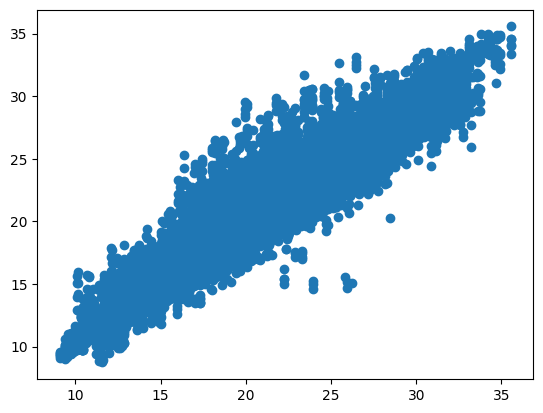

In [22]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.show()

<AxesSubplot: xlabel='timestamp'>

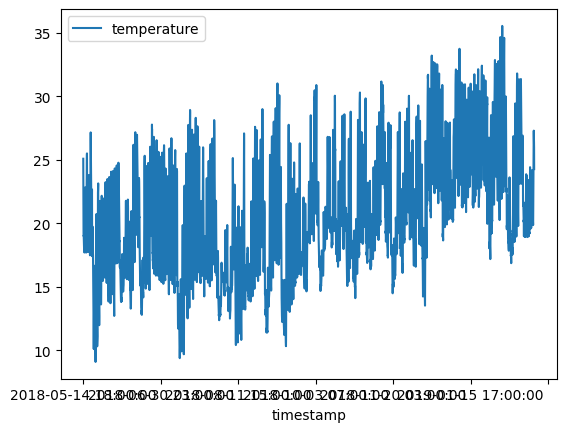

In [23]:
test = cge[X_test.index[0]:X_test.index[-1]][["timestamp", "temperature"]].set_index("timestamp")
test.plot()

In [24]:
test.index = pd.to_datetime(test.index)
test 

,temperature
timestamp,
2018-05-14 18:00:00,25.091000
2018-05-14 19:00:00,23.649333
2018-05-14 20:00:00,20.688333
2018-05-14 21:00:00,19.178833
2018-05-14 22:00:00,19.014667
...,...
2019-02-18 18:00:00,27.068333
2019-02-18 19:00:00,26.657000
2019-02-18 20:00:00,26.392000


In [25]:
ts.timestamp = pd.to_datetime(ts.timestamp)
y_pred["timestamp"] = ts[y_pred.index[0]:y_pred.index[-1]]["timestamp"]
y_pred = y_pred.dropna()
y_pred

,temperature_step_1,temperature_step_2,temperature_step_3,temperature_step_4,temperature_step_5,temperature_step_6,timestamp
20261,25.131666,24.051903,22.325139,20.672792,19.615850,19.063262,2018-05-14 19:00:00
20262,23.640676,21.770318,20.346794,19.483371,19.029931,18.883206,2018-05-14 20:00:00
20263,20.707070,19.087931,18.445136,18.132909,18.039720,17.958133,2018-05-14 21:00:00
20264,19.237772,18.982715,18.792955,18.671287,18.518229,18.342194,2018-05-14 22:00:00
20265,19.044687,18.790212,18.587455,18.400629,18.268684,18.185873,2018-05-14 23:00:00
...,...,...,...,...,...,...,...
26976,25.129694,26.076046,26.603885,27.029402,27.079397,26.615543,2019-02-18 14:00:00
26977,26.064846,26.683730,27.167636,27.206046,26.792591,25.916632,2019-02-18 15:00:00
26978,26.805516,27.363425,27.466893,27.040645,26.083919,24.234013,2019-02-18 16:00:00
26979,26.902597,27.016754,26.675070,25.809598,24.031942,22.574764,2019-02-18 17:00:00


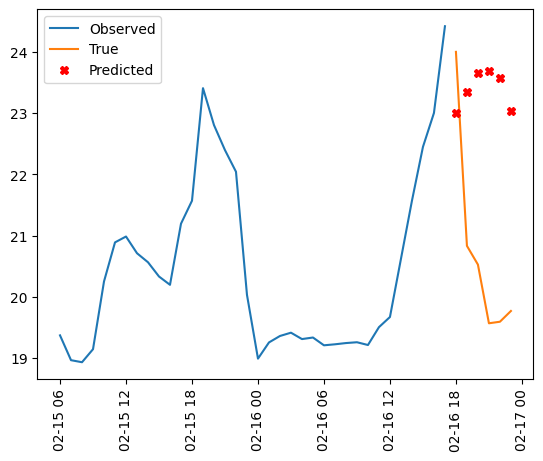

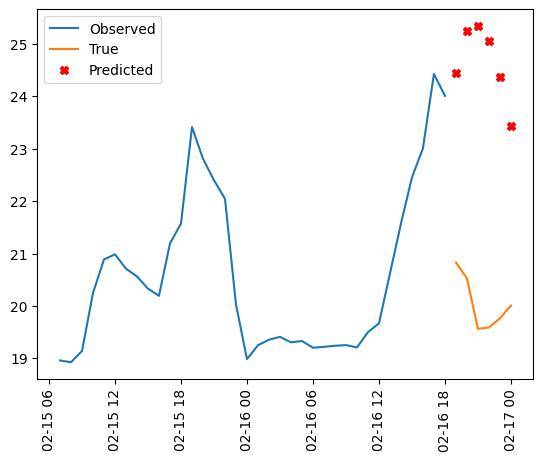

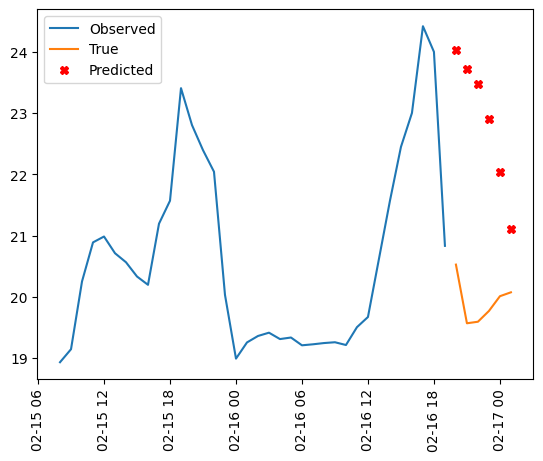

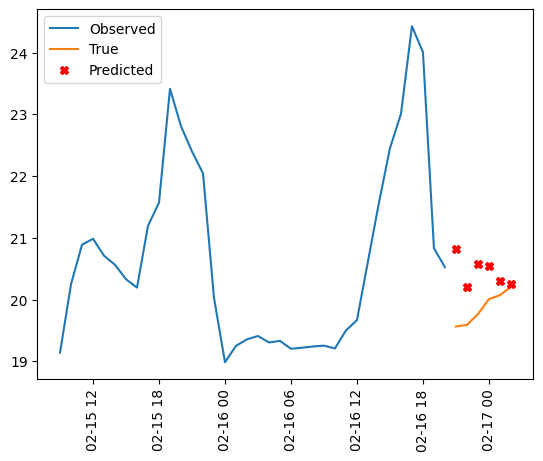

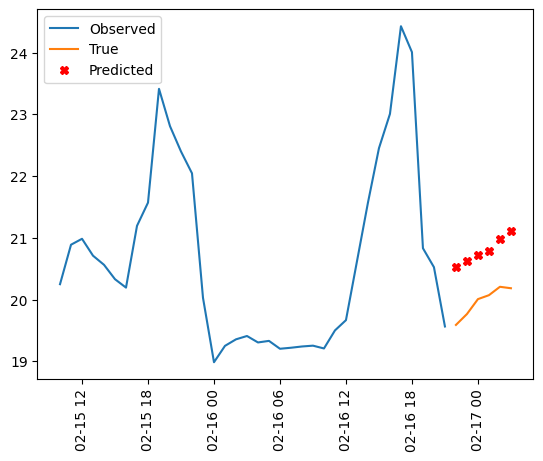

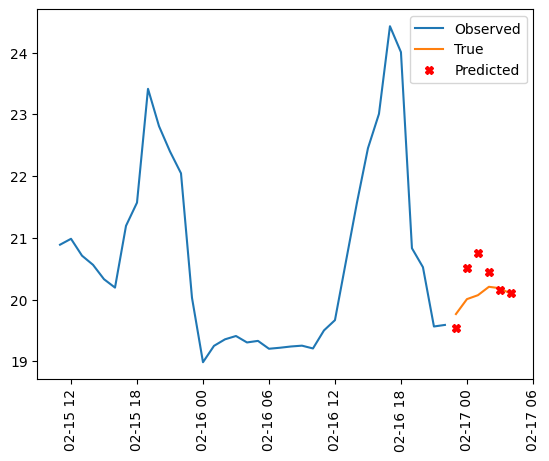

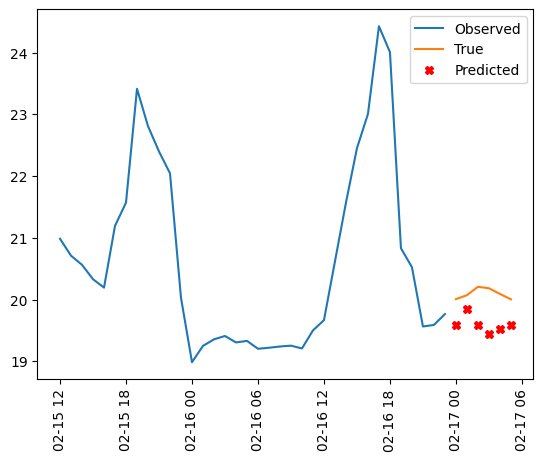

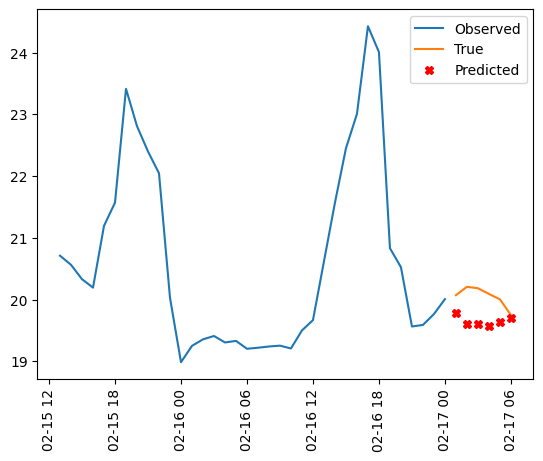

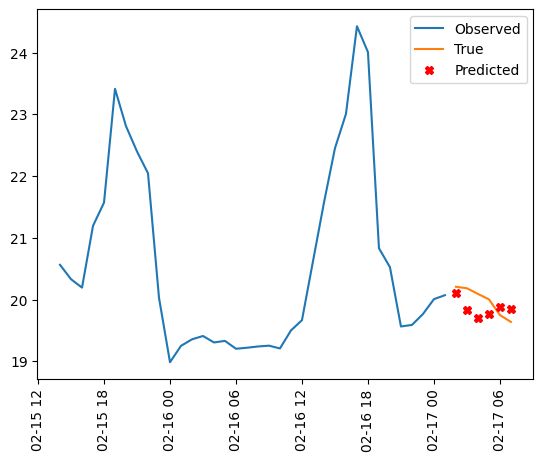

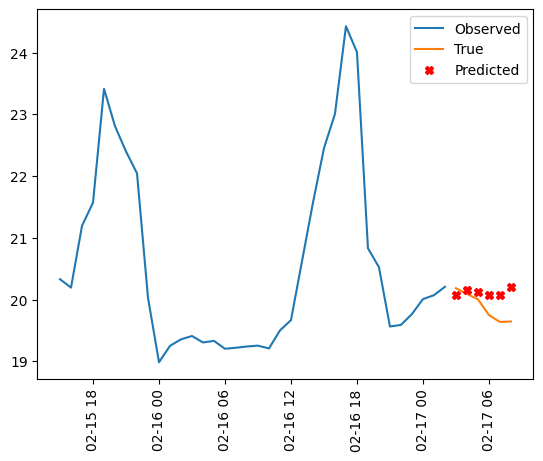

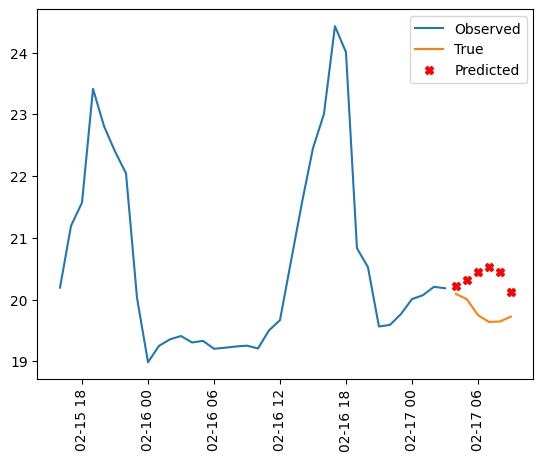

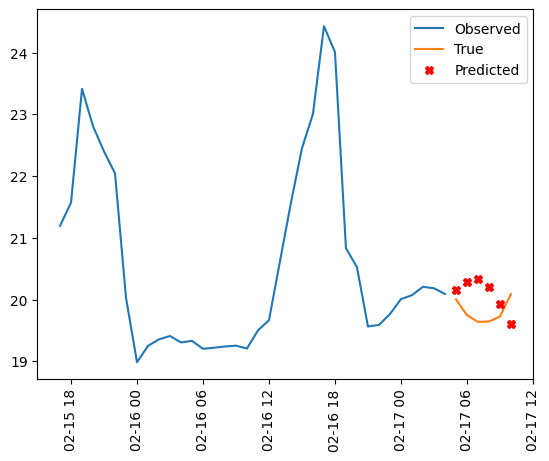

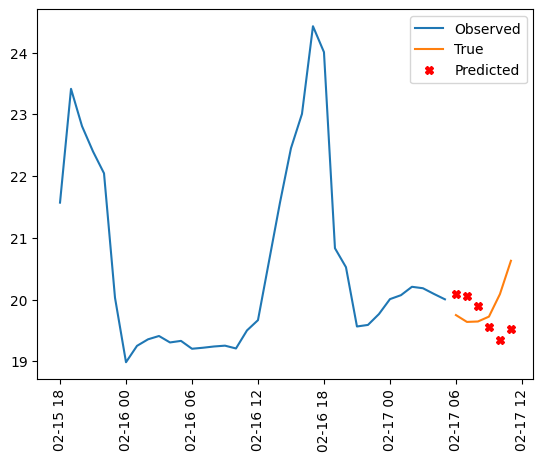

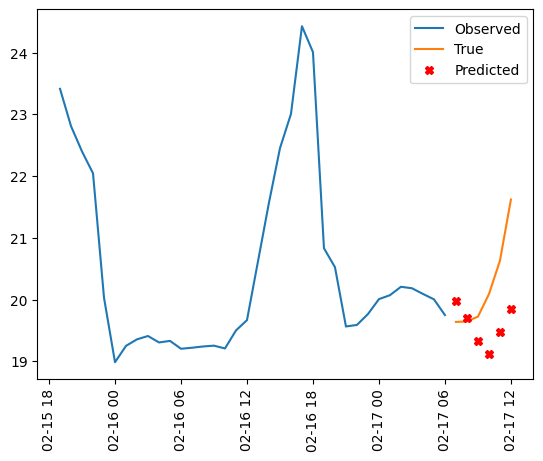

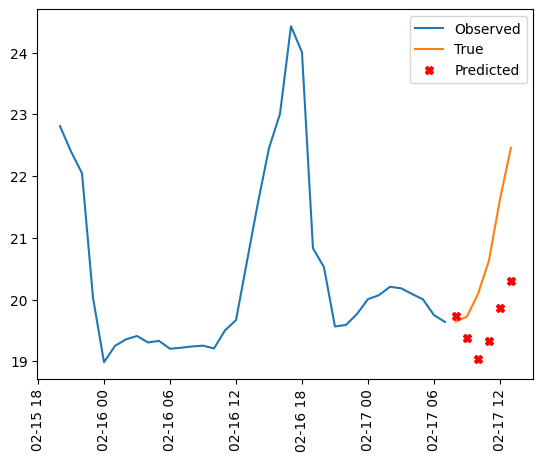

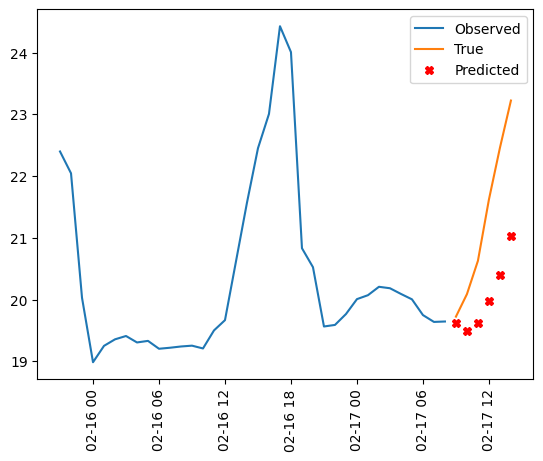

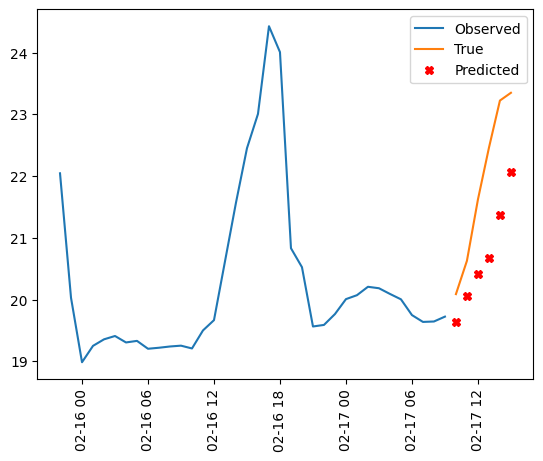

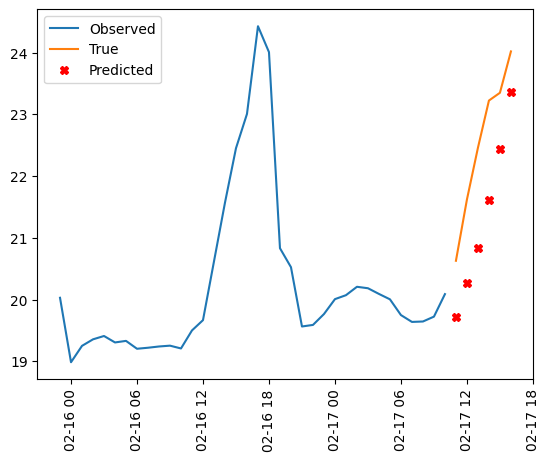

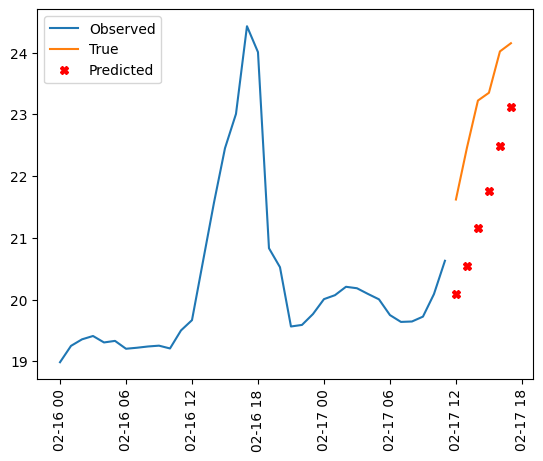

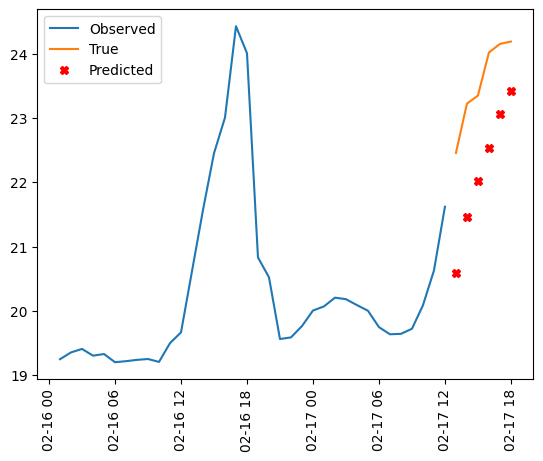

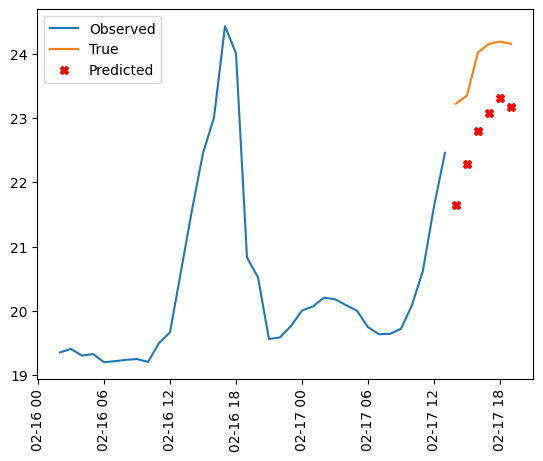

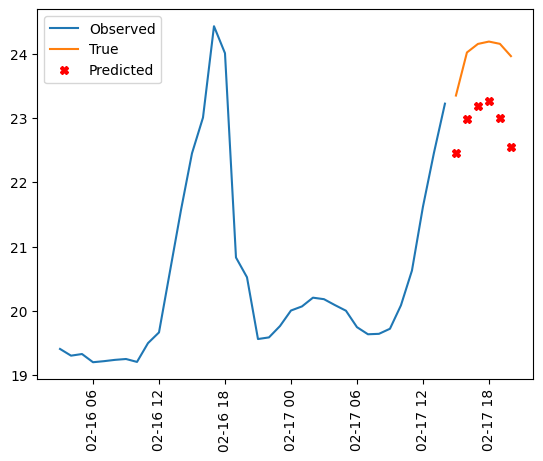

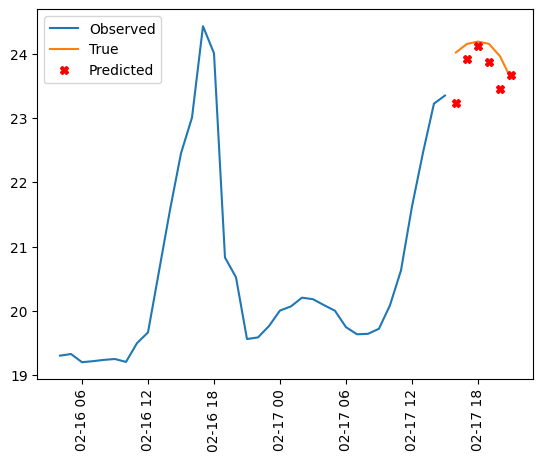

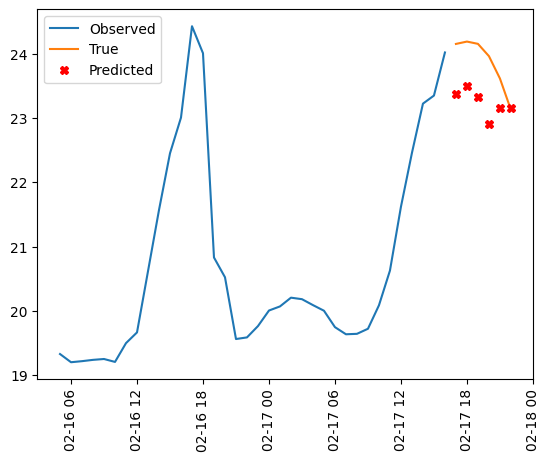

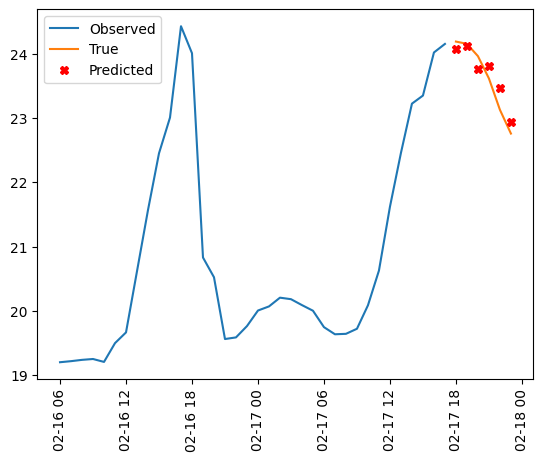

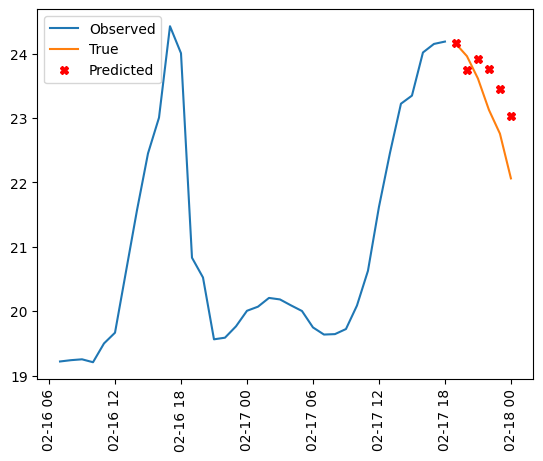

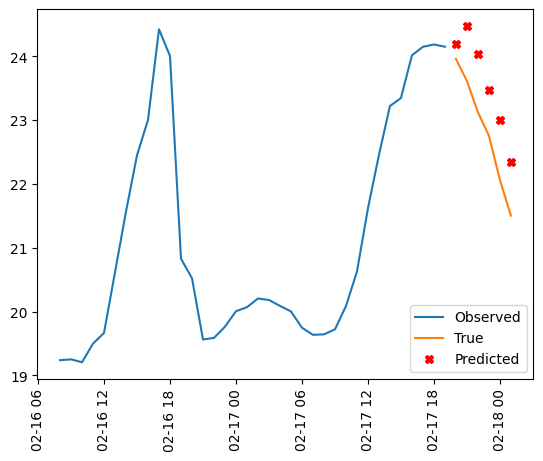

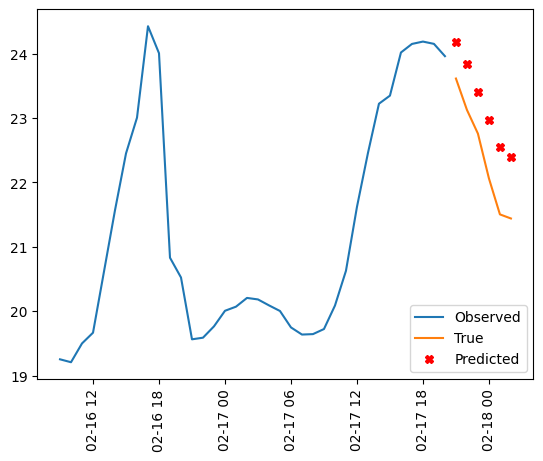

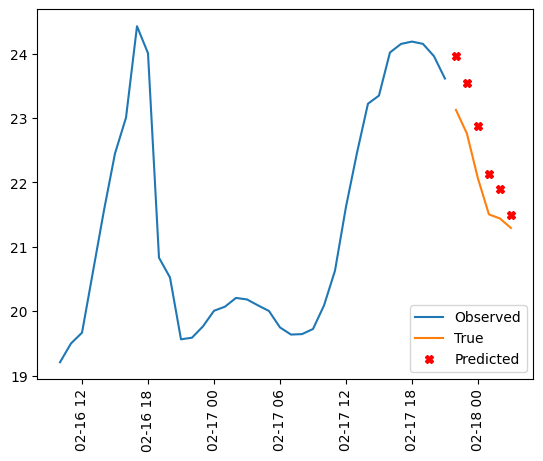

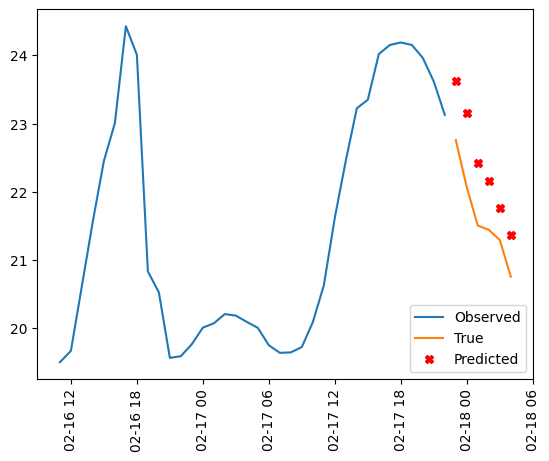

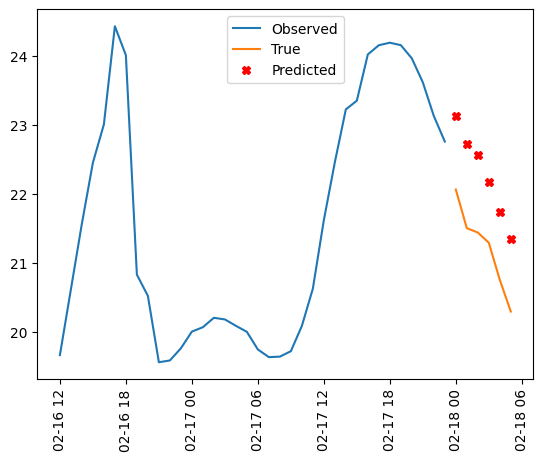

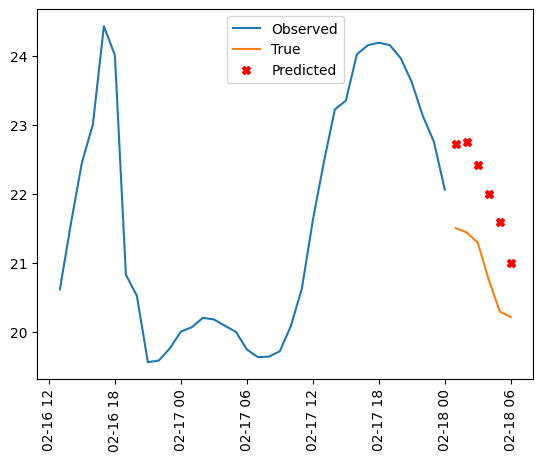

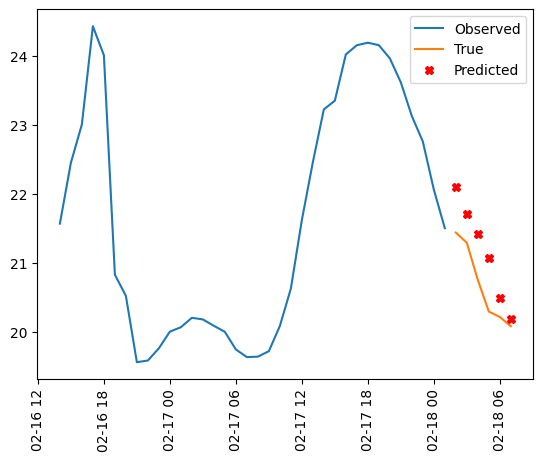

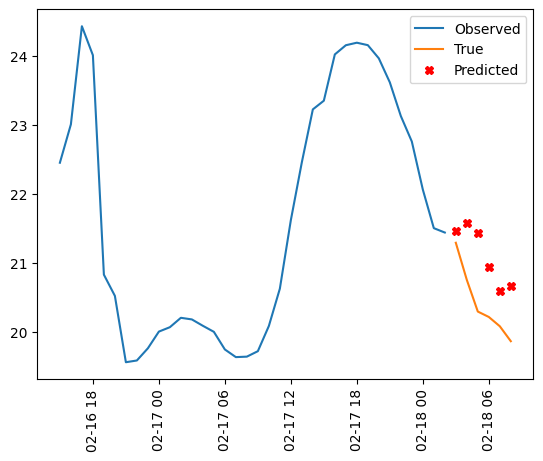

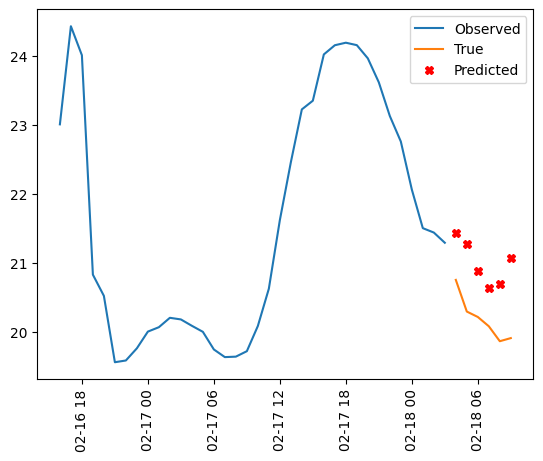

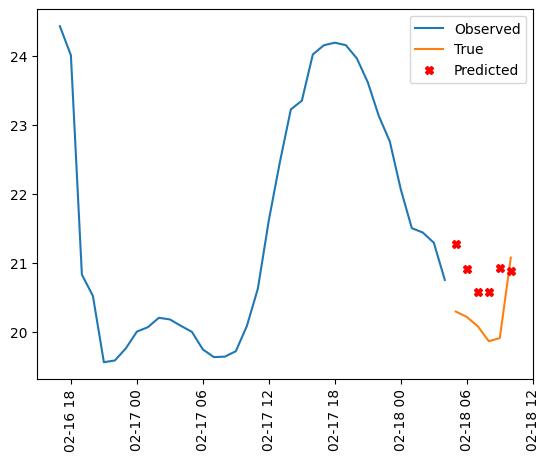

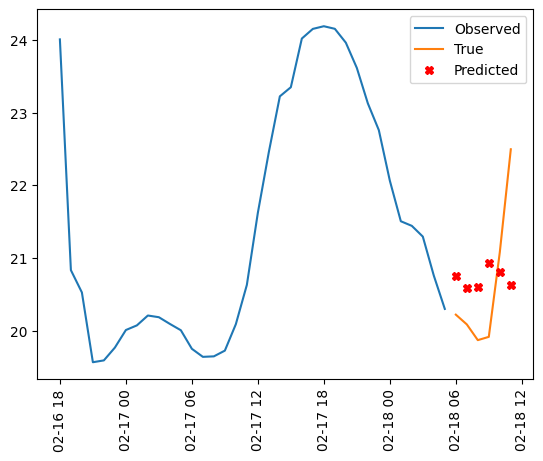

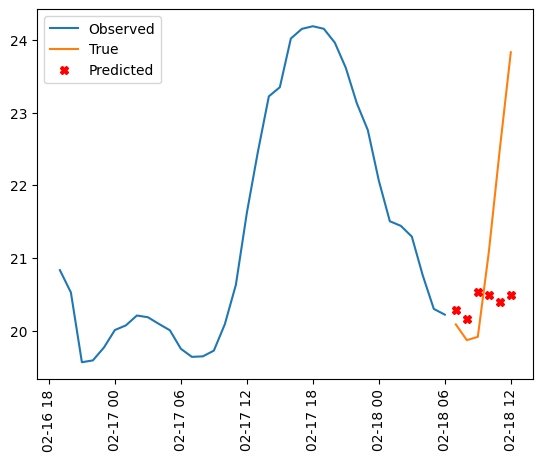

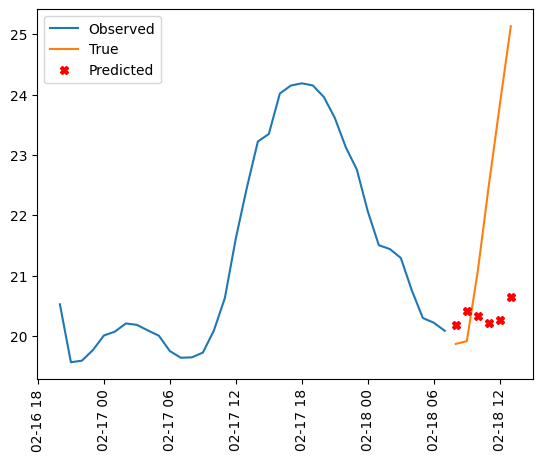

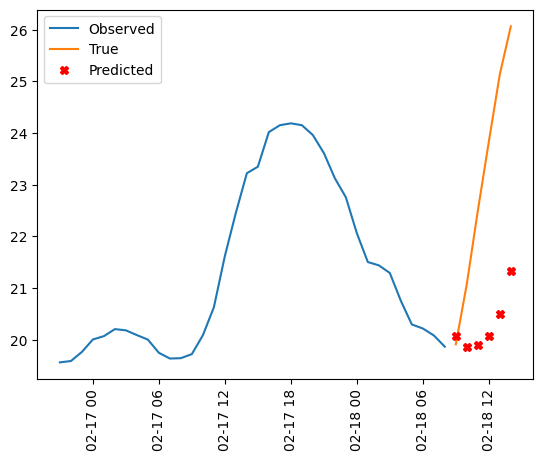

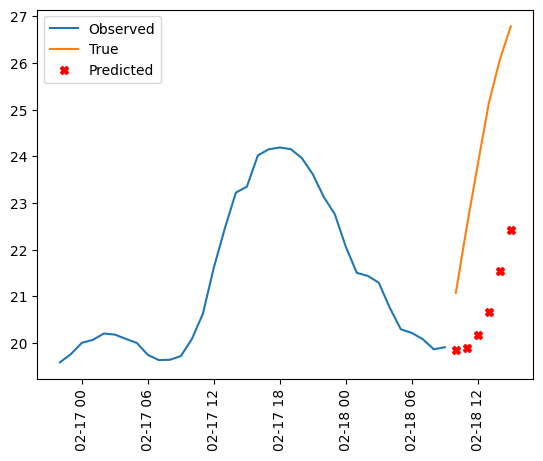

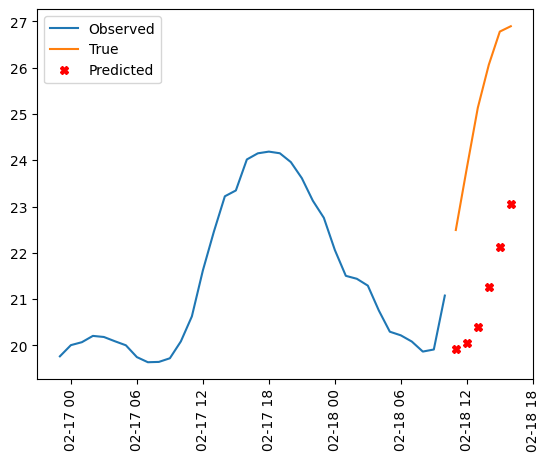

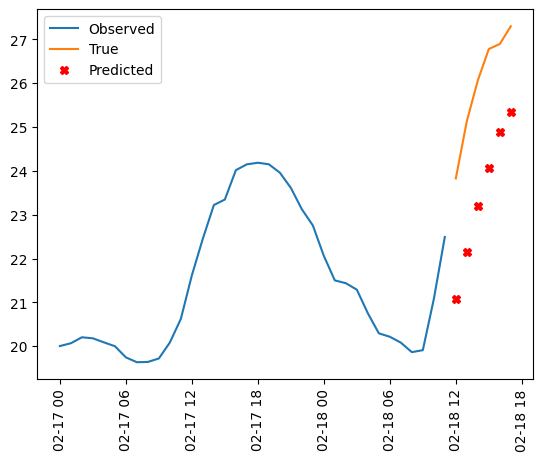

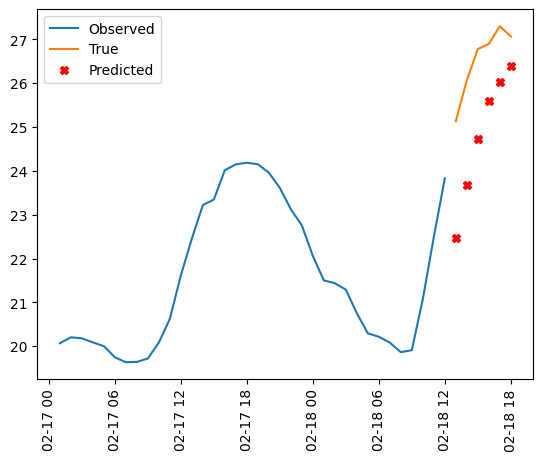

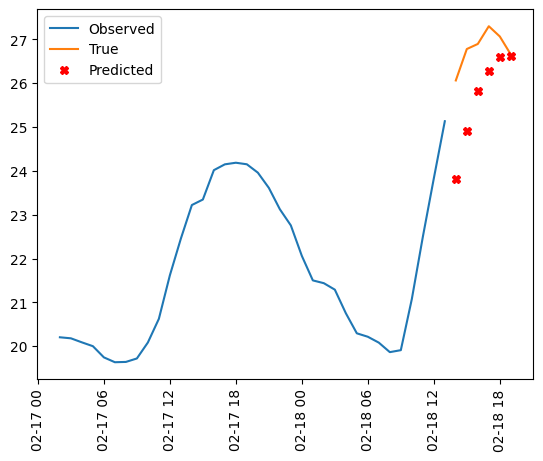

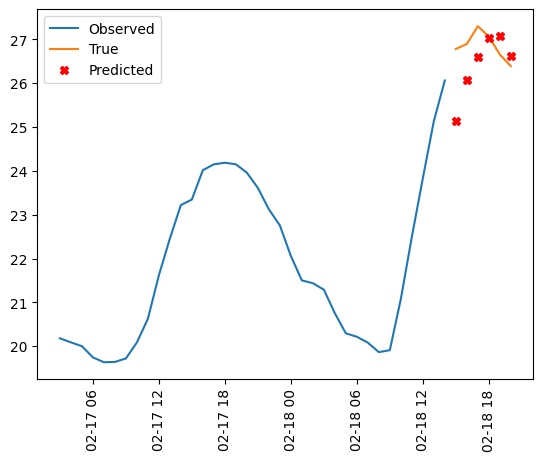

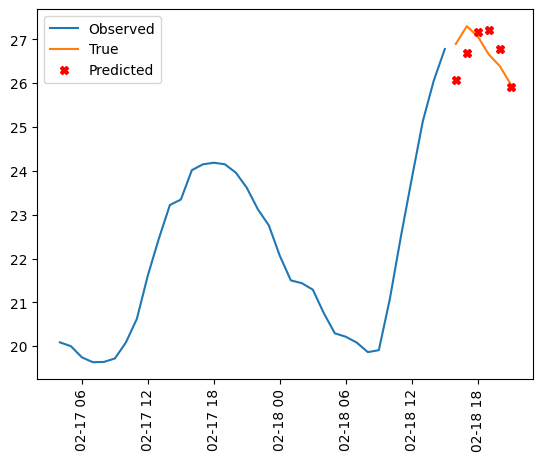

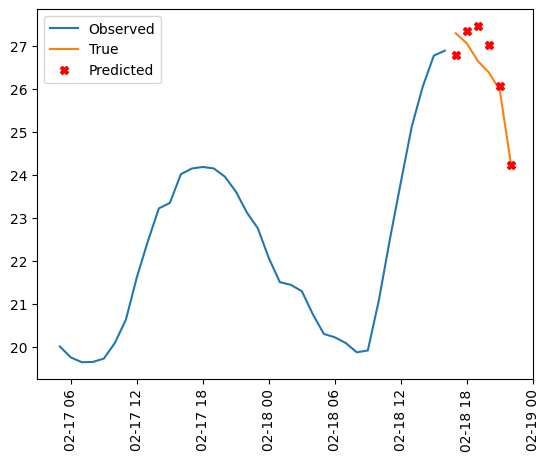

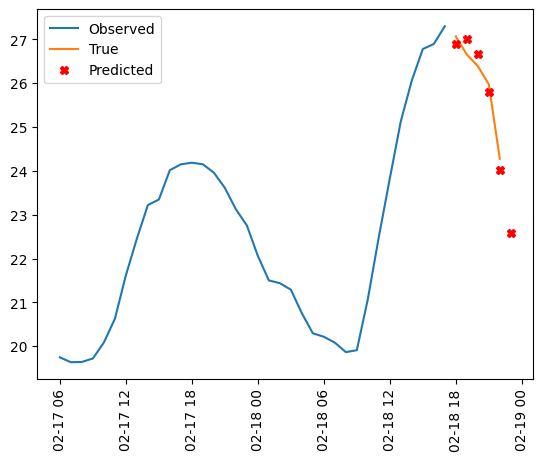

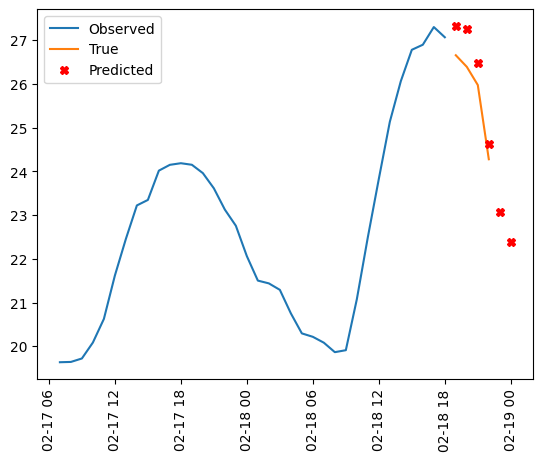

In [26]:
import numpy as np

for i in y_pred.index[-50:]:
    pred = y_pred.loc[[i]]
    start_date = pred.timestamp.unique()[0] + np.timedelta64(1,'h')
    pred = pred.drop("timestamp", axis=1).T
    pred.index = pd.date_range(start=start_date, periods=6, freq="H")
    pred.columns = ["temperature"]

    train_plot = test[pred.index[0]-np.timedelta64(36,'h'):pred.index[0]-np.timedelta64(1,'h')]
    test_plot = test[pred.index[0]:pred.index[-1]]

    plt.plot(train_plot, label="Observed")
    plt.plot(test_plot, label="True")
    plt.plot(pred, label="Predicted", ls="", marker="X", color="red")
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()